In [141]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm, multivariate_normal

# Przykładowy zestaw danych

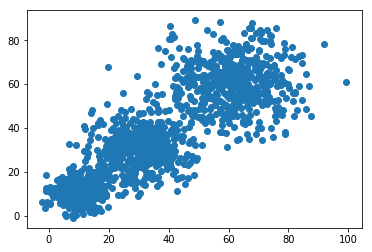

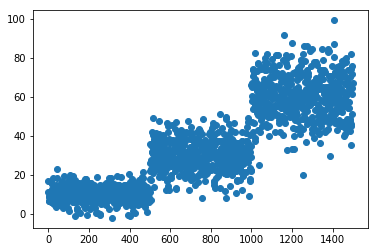

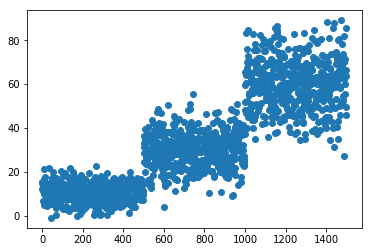

In [3]:
data = np.concatenate((4*np.random.randn(500, 2) + 10,
                       8*np.random.randn(500, 2) + 30,
                       12*np.random.randn(500, 2) + 60))

plt.figure()
plt.scatter(*data.T)
plt.show()

plt.figure()
plt.plot(data.T[0], 'o')
plt.show()

plt.figure()
plt.plot(data.T[1], 'o')
plt.show()

# plt.figure()
# plt.hist(data.T[0], bins=50, normed=True)
# plt.show()

# Wykres rozkładu GMM

In [4]:
def PlotGMM(data, probabilities_of_selection, mean, standard_deviation):
    plt.figure()
    plt.hist(data, bins=50, normed=True)
    sample_x = np.linspace(data.min() - 0.1 * (data.max() - data.min()),
                           data.max() + 0.1 * (data.max() - data.min()), 100)[np.newaxis].T
    sample_y = ((norm.pdf(sample_x,
                          loc = mean,
                          scale = np.sqrt(standard_deviation)) * probabilities_of_selection)
                .sum(axis=1))
    plt.plot(sample_x, sample_y, 'r-')
    plt.show()

In [146]:
def Plot2D(data, probabilities_of_selection, mean, covariance):
    fig = plt.figure()
    plt.scatter(*data.T, alpha=0.5)
    linspace_start = data.min(axis=0) - 0.1 * (data.max(axis=0) - data.min(axis=0))
    linspace_stop = data.max(axis=0) + 0.1 * (data.max(axis=0) - data.min(axis=0))
    sample_x = np.linspace(linspace_start[0], linspace_stop[0], 100)
    sample_y = np.linspace(linspace_start[1], linspace_stop[1], 100)
    xx, yy = np.meshgrid(sample_x, sample_y)
    xx = xx.flatten()[:, np.newaxis]
    yy = yy.flatten()[:, np.newaxis]
    xy_pairs = np.concatenate((xx, yy), axis=1)
#     sample_z = multivariate_normal.pdf(xy_pairs, mean = mean[0], cov = covariance[0]).reshape([100, 100])
    sample_z = np.array(
        [multivariate_normal.pdf(xy_pairs, mean = mean[i], cov = covariance[i]).reshape([100, 100]) 
         for i in range(covariance.shape[0])])
    [plt.contour(sample_x, sample_y, sample_z[i]) for i in range(covariance.shape[0])]
    plt.show()

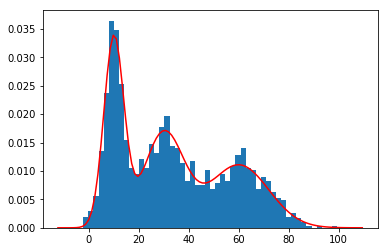

In [97]:
PlotGMM(data.T[0], np.array([0.3333, 0.3333, 0.3333]), np.array([10.0, 30.0, 60.0]), np.array([16.0, 64.0, 144.0]))

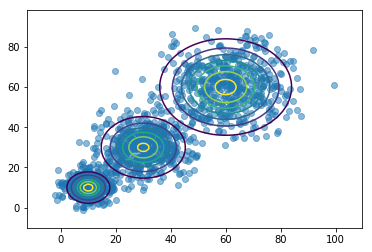

In [147]:
Plot2D(data, np.array([0.3333, 0.3333, 0.3333]),
       np.array([[10., 10.],
                 [30., 30.],
                 [60., 60.]]),
       np.array([[[ 16.,  0.],
                  [  0., 16.]],
                 [[ 64.,  0.],
                  [  0., 64.]],
                 [[144.,  0.],
                  [  0.,144.]]]))

# Algorytm EM

Rozpatrujemy przypadek dwuwymiarowy ($d = 2$). Zestaw danych uczących składa się z $N$ dwuwymiarowych wektorów danych $x_1, x_2, \ldots, x_N \in \mathbb{R^2}$.

Rozpatrujemy mieszaninę $K$ dwuwymiarowych niezależnych rozkładów gaussowskich. Prawdopodobieństwa wyboru kolejnych składników mieszaniny to $p_1, p_2, \ldots, p_K \in \mathbb{R}$. Wartości oczekiwane i odchylenia standardowe kolejnych składników mieszaniny to, odpowiednio, $m_1, m_2, \ldots, m_K \in \mathbb{R^2}$ i $s_1, s_2, \ldots, s_K \in \mathbb{R^{2 \times 2}}$. Niech $\mathbf{p} = (p_1, p_2, \ldots, p_K) \in \mathbb{R}^K$, $\mathbf{m} = (m_1, m_2, \ldots, m_K) \in \mathbb{R^{2\times K}}$, $\mathbf{s} = (s_1, s_2, \ldots, s_K) \in \mathbb{R^{2 \times 2 \times K}}$.

Niech $R$ oznacza ukrytą zmienną losową określającą składnik mieszaniny użyty w losowanu wektora danych. Losując wektory danych, losowano też wartości zmiennej losowej $R$, lecz nie zostały one zapisane w zestawie danych uczących i nie są one znane (jest to ukryta zmienna losowa). Oznaczmy je przez $r_1, r_2, \ldots, r_N \in \mathbb{R}$. Dla wygody dalszych obliczeń wprowadźmy współczynniki $r_{ik} \in \mathbb{R}$, dla $i = 1, 2, \ldots, N$ i $k = 1, 2, \ldots, K$, takie że $r_{ik} = 1$ jeśli $r_i = k$ oraz $r_{ik} = 0$ w przeciwnym przypadku. 

Funkcja wiarygodności ma postać:
$$L(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = P(x_1, x_2, \ldots, x_N | \mathbf{p}, \mathbf{m}, \mathbf{s}) = \prod_{i=1}^N P(x_i | \mathbf{p}, \mathbf{m}, \mathbf{s}) = \prod_{i=1}^N \sum_{k=1}^K r_{ik} p_k P(x_i | m_k, s_k) = \prod_{i=1}^N \sum_{k=1}^K r_{ik} p_k f(x_i; m_k, s_k),$$
gdzie
$$f(X; \boldsymbol{\mu}, \Sigma) = \frac{1}{2 \pi \left|\Sigma\right|} 
\exp\left(-\frac{1}{2}(X-\boldsymbol{\mu})^T\Sigma^{-1}(X-\boldsymbol{\mu})\right).$$

Możemy zlogartymować funkcję wiarygodności, a ponieważ dla każdego $i$, tylko jeden składnik wewnętrznej sumy jest niezerowy (bo punkt danych $x_i$ pochodzi z dokładnie jednego składnika mieszaniny, tzn. współczynnik $r_{ik}$ jest niezerowy dla dokładniej jednego $k$), to z logarytmem można wejść pod wewnętrzną sumę:
$$l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \log L(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N \sum_{k=1}^K r_{ik} \log[p_k f(x_i; m_k, s_k)],$$
skąd
$$l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N \sum_{k=1}^K r_{ik} [\log(p_k) - \frac{1}{2}\log(\text{det}(s_k)) - \log(2 \pi) - \frac{1}{2}(x_i-m_k)^T s_k^{-1}(x_i-m_k)].$$



## Krok E:

Krok E polega na estymacji wartości ukrytej zmiennej losowej $R$ (przy ustalonych wartościach parametrów $\mathbf{p}$, $\mathbf{m}$, $\mathbf{s}$).

$$r_{ik} = P(R = k | x_i) = \frac{p_k f(x_i; m_k, s_k)}{\sum_{j=0}^K p_j f(x_i; m_j, s_j)}$$



## Krok M:

Krok M polega na wyznaczeniu wartości parametrów $\mathbf{p}$, $\mathbf{m}$, $\mathbf{s}$ maksymalizujących funkcję wiarygodności (przy ustalonych wartościach ukrytej zmiennej losowej $R$).

W celu wyznaczenia wartości parametru $\mathbf{p}$ stosujemy metodę mnożników Lagrange'a dla funkcji wiarygodności i warunku $\sum_{k=1}^K p_k = 1$:
$$\frac{\partial}{\partial p_l} l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N r_{il} \frac{1}{p_l} = p_l^{-1} \sum_{i=1}^N r_{il}$$
$$\frac{\partial}{\partial p_l} \sum_{k=1}^K p_k = 1,$$
skąd
$$p_l = \lambda \sum_{i=1}^N r_{il},$$
dla pewnego współczynnika Lagrange'a $\lambda \in \mathbb{R}$, a ponieważ
$$1 = \sum_{k=1}^K p_k = \sum_{k=1}^K \lambda \sum_{i=1}^N r_{ik} = \lambda \sum_{k=1}^K \sum_{i=1}^N r_{ik} = \lambda \sum_{i=1}^N \sum_{k=1}^K r_{ik} = \lambda \sum_{i=1}^N 1 = \lambda N,$$
to $\lambda = \frac{1}{N}$, zatem
$$p_l = \frac{1}{N} \sum_{i=1}^N r_{il}.$$

W celu wyznaczenia wartości parametru $\mathbf{m}$ przyrównujemy do zera pochodną
$$
\frac{\partial}{\partial m_l} l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = 
\frac{\partial}{\partial m_l} \sum_{i=1}^N \sum_{k=1}^K r_{ik} [\log(p_k) - \frac{1}{2}\log(\text{det}(s_k)) - \log(2 \pi) - \frac{1}{2}(x_i-m_k)^T s_k^{-1}(x_i-m_k)] = $$
$$ \frac{\partial}{\partial m_l} \sum_{i=1}^N r_{il} \left(- \frac{1}{2}(x_i-m_l)^T s_k^{-1}(x_i-m_l)\right) = 
\sum_{i=1}^N r_{il} \frac{\partial}{\partial m_l} \left(- \frac{1}{2}(x_i-m_l)^T s_k^{-1}(x_i-m_l)\right) = 
\sum_{i=1}^N r_{il} \left(- \frac{1}{2}\left((x_i-m_l)^Ts_l^{-1}\left(\frac{\partial}{\partial m_l}(x_i-m_l)\right) + (x_i-m_l)^T\left(s_l^{-1}\right)^T\left(\frac{\partial}{\partial m_l}(x_i-m_l)\right)\right)\right)
= \sum_{i=1}^N r_{il} \left(\frac{1}{2}(x_i-m_l)^T\left(s_l^{-1}+\left(s_l^{-1}\right)^T\right)\right)$$

$$\frac{\partial}{\partial m_l} l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N r_{il} \left(\frac{1}{2}(x_i-m_l)^T\left(s_l^{-1}+\left(s_l^{-1}\right)^T\right)\right) = \frac{1}{2}\left(\sum_{i=1}^N r_{il} x_i^T - m_l^T \sum_{i=1}^N r_{il}\right)\left(s_l^{-1}+\left(s_l^{-1}\right)^T\right),$$
skąd
$$m_l = \left(\frac{\sum_{i=1}^N r_{il} x_i^T}{\sum_{i=1}^N r_{il}}\right)^T = \frac{\sum_{i=1}^N r_{il} x_i}{N p_l}.$$

Podobnie, w celu wyznaczenia wartości parametru $\mathbf{s}$ przyrównujemy do zera pochodną
$$\frac{\partial}{\partial s_l} l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = 
\frac{\partial}{\partial s_l} \sum_{i=1}^N r_{il} \left(- \frac{1}{2}\log(\text{det}(s_l)) - \frac{1}{2}(x_i-m_l)^T s_l^{-1}(x_i-m_l)\right) = 
\sum_{i=1}^N r_{il} \left(-\frac{1}{2}s_l^{-1} - \frac{1}{2} \frac{\partial}{\partial s_l} (x_i-m_l)^Ts_l^{-1}(x_i-m_l)\right) = \sum_{i=1}^N  r_{il} \left(-\frac{1}{2}s_l^{-1} -\frac{1}{2}s_l^{-1}(x_i-m_l)(x_i-m_l)^Ts_l^{-1}\right)$$
$$\frac{\partial}{\partial s_l} l(\mathbf{p}, \mathbf{m}, \mathbf{s} | x_1, x_2, \ldots, x_N) = \sum_{i=1}^N  r_{il} \left(-\frac{1}{2}s_l^{-1} -\frac{1}{2}s_l^{-1}(x_i-m_l)(x_i-m_l)^Ts_l^{-1}\right) = -\frac{1}{2} \left(s_l^{-1}\sum_{i=1}^N r_{il} (x_i-m_l)(x_i-m_l)^T - \sum_{i=1}^N r_{il}\right)s_l^{-1},$$
skąd
$$s_l = \frac{\sum_{i=1}^N r_{il} (x_i-m_l)(x_i-m_l)^T}{\sum_{i=1}^N r_{il}} = \frac{\sum_{i=1}^N r_{il} (x_i-m_l)(x_i-m_l)^T}{N p_l}.$$

In [136]:
def EM(data, K, iterations):
    dimension = 2
    N = data.shape[0]

    p = np.random.rand(K)
    p = p / np.sum(p)

    m = np.linspace(data.min(), data.max(), K*dimension + 2)[1:-1].reshape([K, dimension])

    s = np.array(K * [np.identity(dimension)])

    loglikelihood = np.zeros(iterations)
    loglikelihood_optimal = - np.inf
    p_optimal = p
    m_optimal = m
    s_optimal = s

    for t in range(iterations):
        R = p * np.array(
            [multivariate_normal.pdf(data, mean = m[i], cov = s[i]) for i in range(K)]).T
        for i, c in enumerate(R):
            if c.sum() == 0:
                # print(i, c, c.sum())
                R[i] = np.array([1/3, 1/3, 1/3])
        R = R / R.sum(axis = 1)[np.newaxis].T  # hidden variable

        p = R.sum(axis = 0) / N
        m = (R.T @ data) / (N * p[:, np.newaxis])
        
        for i in range(s.shape[0]):
            s[i] = ((data - m[i]).T @ (R.T[i][:, np.newaxis] * (data - m[i]))) / (N * p[i])

        loglikelihood[t] = (R * np.log(np.array(
            [multivariate_normal.pdf(data, mean = m[i], cov = s[i]) for i in range(K)]).T * p)).sum()

        if loglikelihood_optimal < loglikelihood[t]:
            loglikelihood_optimal = loglikelihood[t]
            p_optimal = p
            m_optimal = m
            s_optimal = s

    return p_optimal, m_optimal, s_optimal, loglikelihood

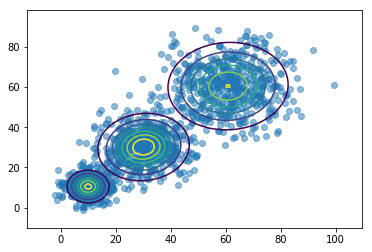

[ 0.33122775  0.33810346  0.33066879]
[[  9.91542184  10.51018058]
 [ 30.11442977  30.13903809]
 [ 60.87049415  60.45094112]]
[[[  15.69574019   -0.223989  ]
  [  -0.223989     17.74901702]]

 [[  67.13226343    4.45688851]
  [   4.45688851   68.08925435]]

 [[ 133.07644567    4.34595546]
  [   4.34595546  131.61562288]]]


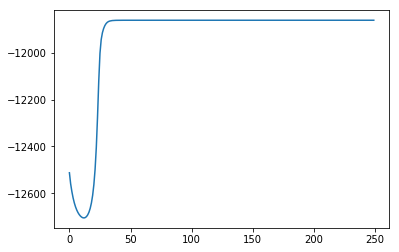

In [138]:
p, m, s, ll = EM(data, 3, 250)

Plot2D(data, p, m, s)

print(p)
print(m)
print(s)

plt.figure()
plt.plot(ll)
plt.show()

In [21]:
p, m, s, ll = EM(data, 3, 250)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [13]:
data.shape

(1500, 2)

In [52]:
a=2*np.ones([3,2])

In [56]:
b=3*np.ones([3])[:, np.newaxis]

In [57]:
a/b

array([[ 0.66666667,  0.66666667],
       [ 0.66666667,  0.66666667],
       [ 0.66666667,  0.66666667]])

In [58]:
a*b

array([[ 6.,  6.],
       [ 6.,  6.],
       [ 6.,  6.]])

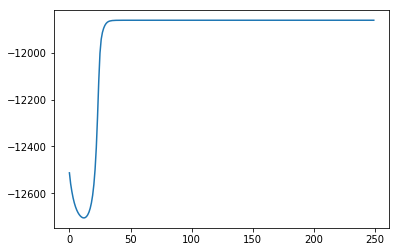

In [25]:
plt.figure()
plt.plot(ll)
plt.show()

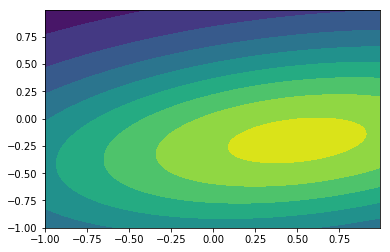

In [24]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
plt.contourf(x, y, rv.pdf(pos))

In [23]:
p, m, s

(array([ 0.33122775,  0.33810346,  0.33066879]),
 array([[  9.91542184,  10.51018058],
        [ 30.11442977,  30.13903809],
        [ 60.87049415,  60.45094112]]),
 array([[[  15.69574019,   -0.223989  ],
         [  -0.223989  ,   17.74901702]],
 
        [[  67.13226343,    4.45688851],
         [   4.45688851,   68.08925435]],
 
        [[ 133.07644567,    4.34595546],
         [   4.34595546,  131.61562288]]]))